# Regression with Tensorflow Probability
#### References
* https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

#### Create Data

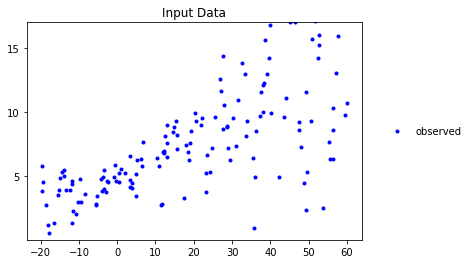

In [2]:
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
    np.random.seed(43)
    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)
    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    x = x[..., np.newaxis]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., np.newaxis]
    return y, x, x_tst

y, x, x_tst = load_dataset()

plt.plot(x, y, 'b.', label='observed');
plt.title('Input Data');
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.show()

#### Negative Log likelihood

In [3]:
def negative_log_likelihood(y, rv_y):
    """
    y: will be our label
    rv_y: will be the probabilistic model output (ie: A normal distribution)
    """
    return -rv_y.log_prob(y)

#### Training a probabilistic model with no uncertainty (Simple linear regresssion)

0.13140531
5.129122


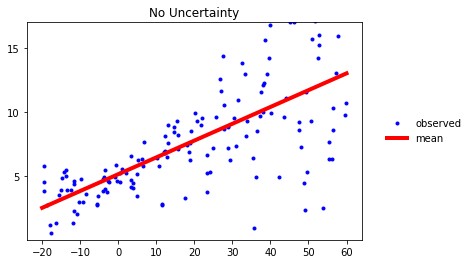

In [4]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  # The model will output a Normal distribution
  tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negative_log_likelihood)
model.fit(x, y, epochs=1000, verbose=False);

# Print model weights
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)

# Plot results
plt.plot(x, y, 'b.', label='observed');
plt.plot(x_tst, yhat.mean(),'r', label='mean', linewidth=4);
plt.title('No Uncertainty');
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.show()

#### With Uncertainty
The uncertainty will be the standard deviation of our predictions

[0.1222197 0.9639441]
[5.1935263 6.0361934]


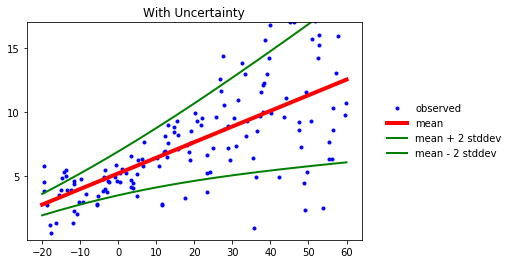

In [7]:
# Build model.
model = tf.keras.Sequential([
  # we want to learn 2 parameters
  tf.keras.layers.Dense(2),
  # The model will output a Normal distribution
  tfp.layers.DistributionLambda(
      lambda t: tfp.distributions.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negative_log_likelihood)
model.fit(x, y, epochs=1000, verbose=False);

# Print model weights
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)

# Plot results
plt.plot(x, y, 'b.', label='observed');
plt.plot(x_tst, yhat.mean(),'r', label='mean', linewidth=4);
plt.plot(x_tst, yhat.mean() + 2 * yhat.stddev(), 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, yhat.mean() - 2 * yhat.stddev(), 'g', linewidth=2, label=r'mean - 2 stddev');
plt.title('With Uncertainty');
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.show()